In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from model import UNet3D
from utils import Crop3D, CTDataset, estimate_global_min_max
from torch.utils.data import DataLoader, random_split,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from lploss import LpLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
a = torch.tensor([[1,2,0,4],
                [1,3,4,5]])
mask = torch.tensor([[0,0,0,1],
                     [1,0,1,0]])
a[torch.logical_not(mask)],torch.logical_not(mask)

SyntaxError: invalid syntax (682630641.py, line 5)

In [6]:
mask = torch.load("/rds/general/user/hw123/home/data_set/Pore_Voxel_Extraction/seg_dry.pt")
mask.shape

torch.Size([1600, 2016, 2016])

In [11]:
mask[1,1000,:].sum()

tensor(1875)

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from model import UNet3D
from utils import Crop3D, CTDataset, estimate_global_min_max
from torch.utils.data import DataLoader, random_split,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from lploss import LpLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

 # Set random seed for reproducibility
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

# Set device
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")
set_seed(42)

base_dir = f'/rds/general/user/hw123/ephemeral/dataset'

transform = Crop3D((224,224,224))

dataset = CTDataset(base_dir=base_dir,transform=transform)

train_ratio = 0.8
val_ratio = 0.2
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


Cuda installed! Running on GPU 0 Quadro RTX 6000!


In [2]:
set_seed(42)
model_epoch_predict = torch.load('../model_U_net_new_loader_mask/model_U_net_randomCrop_Lploss_standardization_epoch15.pth')
model_epoch_predict.eval()

UNet3D(
  (encoder1): ConvBlock(
    (conv): Sequential(
      (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): ConvBlock(
    (conv): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): ConvBlock(
    (conv): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padd

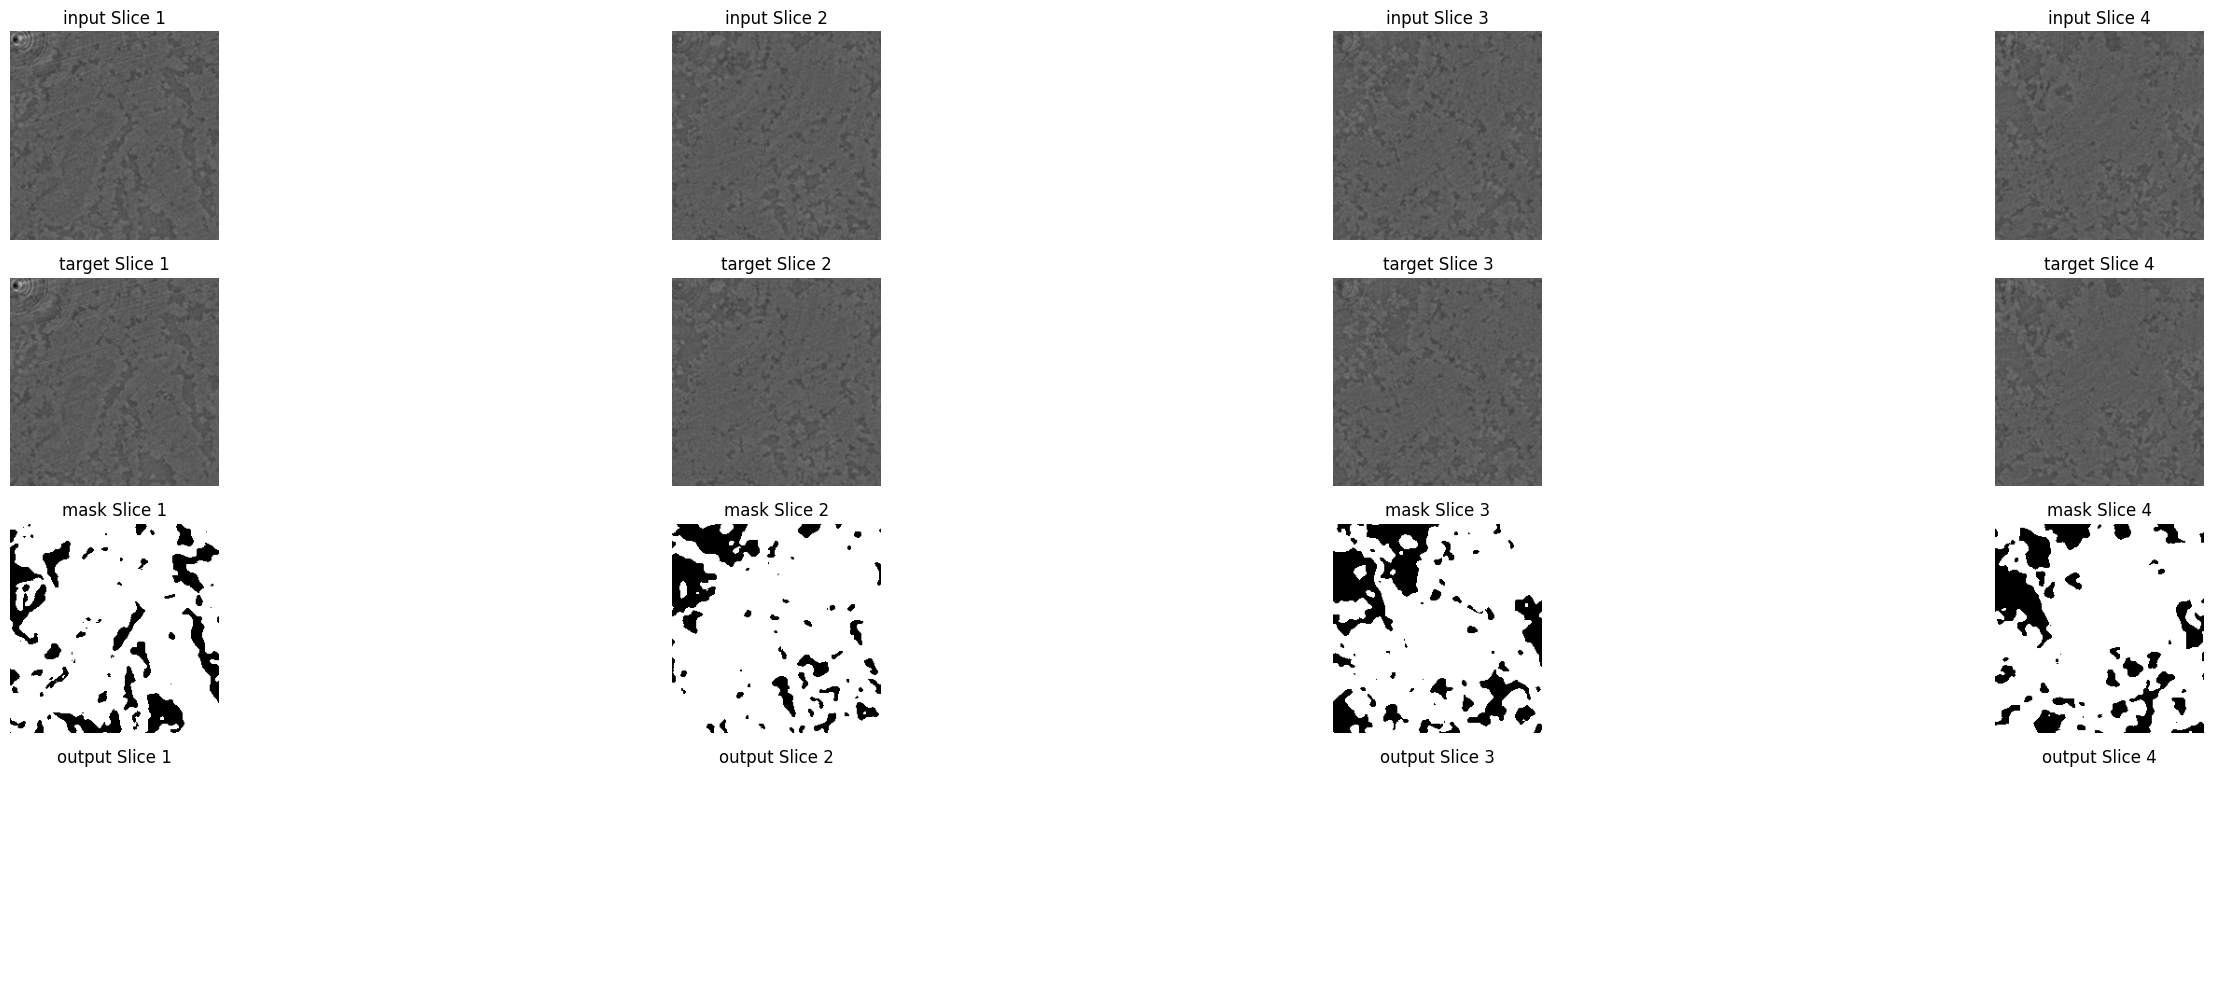

In [3]:

fig, axes = plt.subplots(4, 4, figsize=(30, 10))
input_val, target_val, mask = val_dataset[0]
input_val, target_val, mask = input_val.unsqueeze(0).to(device), target_val.unsqueeze(0).to(device),mask.unsqueeze(0)

# target_val = target_val * (global_max - global_min) + global_min
output_val = model_epoch_predict(input_val)
# output_val = output_val * (global_max - global_min) + global_min
global_min = 0
global_max = 1


for i in range(4):
    axes[0, i].imshow(input_val[0, 0, i*20, :, :].detach().cpu().numpy(), cmap='gray',vmin=global_min, vmax=global_max)
    axes[0, i].set_title(f"input Slice {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(target_val[0, 0, i*20, :, :].detach().cpu().numpy(), cmap='gray', vmin=global_min, vmax=global_max)
    axes[1, i].set_title(f"target Slice {i+1}")
    axes[1, i].axis('off')
    
    axes[2, i].imshow(mask[0, 0, i*20, :, :].detach().cpu().numpy(), cmap='gray', vmin=global_min, vmax=global_max)
    axes[2, i].set_title(f"mask Slice {i+1}")
    axes[2, i].axis('off')
    
    axes[3, i].imshow(output_val[0, 0, i*20, :, :].detach().cpu().numpy(), cmap='gray', vmin=global_min, vmax=global_max)
    axes[3, i].set_title(f"output Slice {i+1}")
    axes[3, i].axis('off')
    
plt.tight_layout()
# plt.colorbar()
plt.show()

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from model import UNet3D
from utils import Crop3D, CTDataset, estimate_global_min_max
from torch.utils.data import DataLoader, random_split,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from lploss import LpLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

 # Set random seed for reproducibility
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

# Set device
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")
set_seed(42)

base_dir = f'/rds/general/user/hw123/ephemeral/dataset'

transform = Crop3D((224,224,224))

dataset = CTDataset(base_dir=base_dir,transform=transform)

train_ratio = 0.8
val_ratio = 0.2
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,num_workers = 2)

learning_rate = 2e-4
num_epochs = 20

model = UNet3D(in_channels=2, out_channels=1, init_features=32).to(device)
criterion = LpLoss(d=3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=True)



Cuda installed! Running on GPU 0 Quadro RTX 6000!


/rds/general/user/hw123/home/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
targets.shape

torch.Size([1, 1, 224, 224, 224])

Training Epoch 1/20:   0%|          | 0/23 [00:00<?, ?it/s]

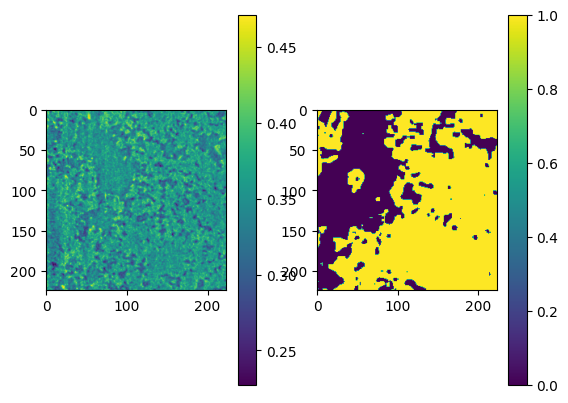

Training Epoch 1/20:   4%|▍         | 1/23 [00:55<20:18, 55.39s/it]

tensor(659453.8125)


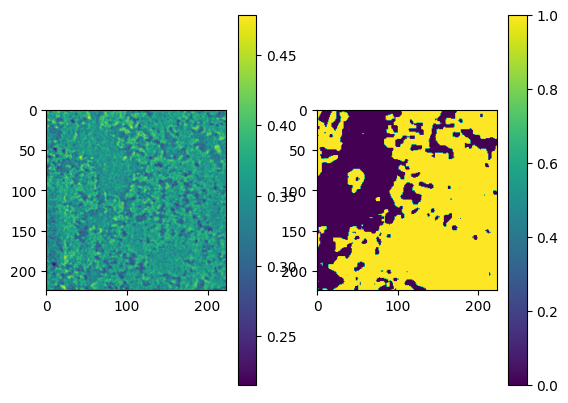

Training Epoch 1/20:   9%|▊         | 2/23 [00:55<08:01, 22.95s/it]

tensor(659487.1250)


Training Epoch 1/20:   9%|▊         | 2/23 [01:14<13:07, 37.49s/it]


KeyboardInterrupt: 

In [10]:
for inputs, targets, mask in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(targets[0,0,:,:,0])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(mask[0,0,:,:,0])
    plt.colorbar()
    plt.show()
    print(torch.norm(targets[torch.logical_not(mask)], 1))

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # 训练循环
    for inputs, targets, mask in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
        

        # 前向传播
        outputs = model(inputs)
        print(outputs[torch.logical_not(mask)].shape)
        print(outputs[torch.logical_not(mask)].mean())
        print(targets[torch.logical_not(mask)].mean())
        loss = criterion(outputs[torch.logical_not(mask)].reshape(1,-1), targets[torch.logical_not(mask)].reshape(1,-1))
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # 计算平均训练损失
    train_loss /= len(train_loader.dataset)
    
    # 验证过程
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets,mask in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs[torch.logical_not(mask)], targets[torch.logical_not(mask)])
            
            val_loss += loss.item() * inputs.size(0)
    
    # 计算平均验证损失
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)
    
    # 打印每个epoch的训练和验证损失
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

#     if (epoch+1) % 5 == 0 or epoch == 0:
#         torch.save(model, f"model_U_net_Crop_Lploss_mask_epoch{epoch+1}.pth")
#         print(f"Model saved as model_U_net_Crop_Lploss_mask_epoch{epoch+1}.pth")



Training Epoch 1/20:   0%|          | 0/23 [00:00<?, ?it/s]

# Plot

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from model import UNet3D
from utils import Crop3D, CTDataset, estimate_global_min_max
from torch.utils.data import DataLoader, random_split,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from lploss import LpLoss

In [2]:
 # Set random seed for reproducibility
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

# Set device
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 Quadro RTX 6000!


In [3]:
device = set_device("cuda")
set_seed(42)

base_dir = f'/rds/general/user/hw123/ephemeral/dataset'

transform = Crop3D((224,224,224))

dataset = CTDataset(base_dir=base_dir,transform=transform)

train_ratio = 0.8
val_ratio = 0.2
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)



Cuda installed! Running on GPU 0 Quadro RTX 6000!


In [4]:
# Global min: 0, Global max: 65535
global_min, global_max = 0, 65535

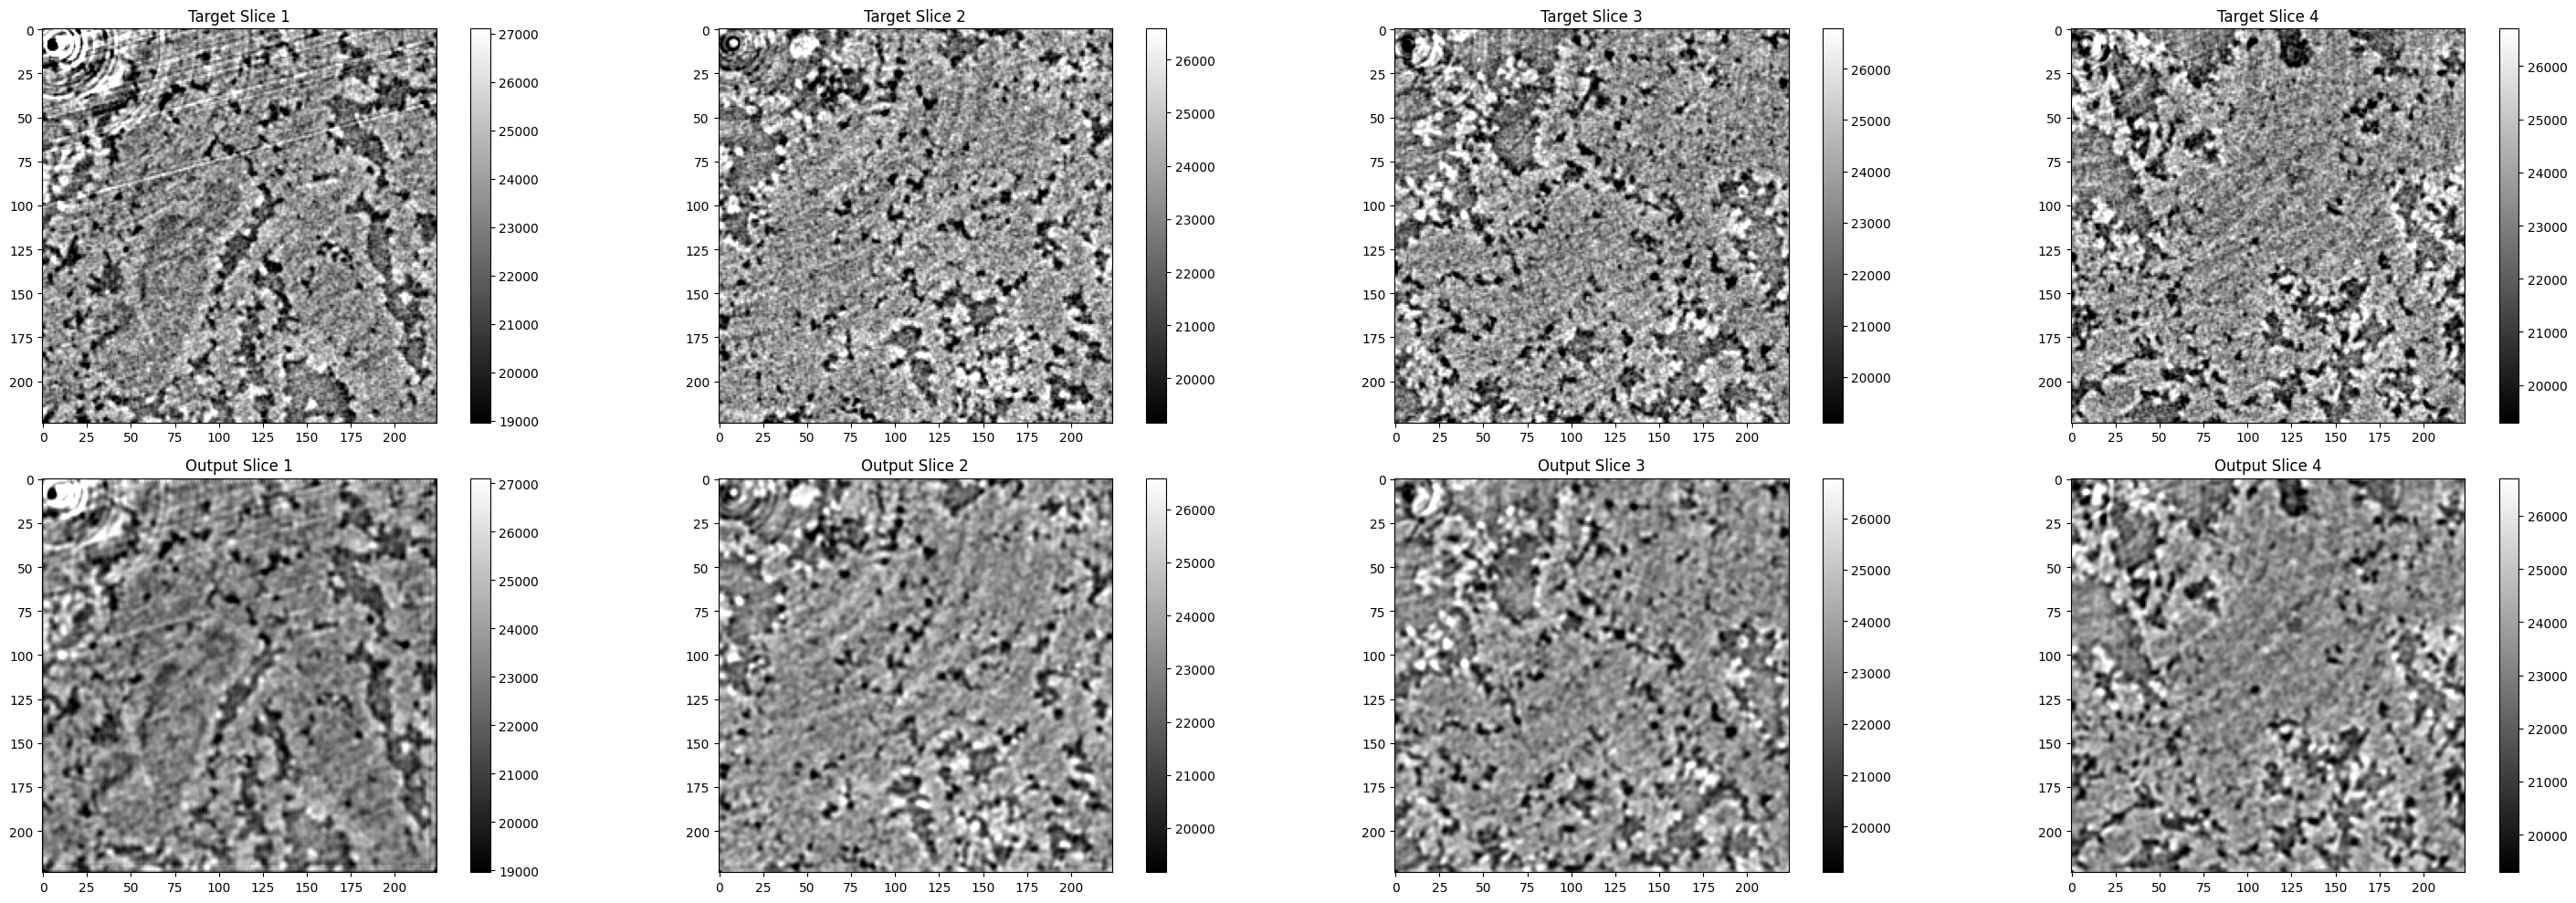

In [6]:
model_epoch_predict = torch.load('../model_U_net_new_loader_mask/model_U_net_Crop_Lploss_mask_epoch20.pth')
model_epoch_predict.eval()
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
input_val, target_val,_ = val_dataset[0]
input_val, target_val = input_val.unsqueeze(0).to(device), target_val.unsqueeze(0).to(device)

target_val = target_val * (global_max - global_min) + global_min
output_val = model_epoch_predict(input_val)
output_val = output_val * (global_max - global_min) + global_min


for i in range(4):
    target_val_plot = target_val[0, 0, i*20, :, :].detach().cpu().numpy()
    output_val_plot = output_val[0, 0, i*20, :, :].detach().cpu().numpy()
    vmin_one_channel = np.percentile(target_val_plot, 2)
    vmax_one_channel = np.percentile(target_val_plot, 98)
    
    
    im1 = axes[0, i].imshow(target_val_plot, cmap='gray',vmin=vmin_one_channel, vmax=vmax_one_channel)
    axes[0, i].set_title(f"Target Slice {i+1}")
    fig.colorbar(im1, ax=axes[0, i])

    im2 = axes[1, i].imshow(output_val_plot, cmap='gray', vmin=vmin_one_channel, vmax=vmax_one_channel)
    axes[1, i].set_title(f"Output Slice {i+1}")
    fig.colorbar(im2, ax=axes[1, i])
plt.tight_layout()
# plt.colorbar()
plt.show()

In [7]:
from sklearn.metrics import r2_score

# 假设你的 target_val 和 output_val 都是 PyTorch 张量，并且形状相同
target_val_flat = target_val.view(-1).detach().cpu().numpy()
output_val_flat = output_val.view(-1).detach().cpu().numpy()

# 使用 sklearn 计算 R² 值
r2 = r2_score(target_val_flat, output_val_flat)

print(f"R^2: {r2:.4f}")

R^2: 0.5884
